<div style="text-align: center;" >
<h1 style="margin-top: 0.2em; margin-bottom: 0.1em;">Assignment 4</h1>

</div>
<br>


## Social Network Analysis of Swiss Politicians on Twitter Data
In this assignment you will do the following tasks:
1. Read a json of retweets
2. Build a graph with this data
3. Visualize the graph

### Install requirements. 

The following cell contains all the necessary dependencies needed for this task. If you run the cell everything will be installed.  

* [`pandas`](https://pandas.pydata.org/docs/index.html) is a Python package for creating and working with tabular data. [Here](https://pandas.pydata.org/docs/reference/index.html) is the documentation of `pandas`.
* [`numpy`](https://numpy.org/) is a Python package for mathematical functions. [Here](https://numpy.org/doc/stable/reference/index.html) is the documentation of `numpy`.
* [`matplotlib`](https://matplotlib.org/) is a Python package for creating plots. [Here](https://matplotlib.org/stable/api/index.html) is the documentation of `matplotlib`.
* [`networkx`](https://networkx.org/) is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks. [Here](https://networkx.org/documentation/stable/reference/index.html) is the documentation of `networkx`.

In [1]:
! pip install pandas
! pip install numpy
! pip install matplotlib
! pip install networkx

### Import requirements
The cell below imports all necessary dependancies. Make sure they are installed (see cell above).

In [34]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import json

### Exercise 1: Load social networks of retweets

The attached `json` file contains tweet information about Swiss politicians for the time between 2021-07-12 and 2022-07-12. 
First, load the json file using `json.loads()`. Note that you have to load each line separtly. 


Hint: You might want to do the following:
* intialize a list to store the results
* use `with open('file_name.json', 'r') as file:` to read the file 
* and then loop over every line in `file` loading the line with `json.loads()` and appending it to your list

In [2]:
swiss_pol=[]
with open('SwissPoliticians-tweets.json', 'r') as file:
    # Read the file line by line
    for line in file:
        # Load each JSON object separately
        data = json.loads(line)
        swiss_pol.append(data)

### Exercise 2: Build a Graph

Now we need to extract the information we need from the json object. Each node in the network should represent a politician, and stores their Twitter user id, username, and party affiliation. An edge exists between a pair of politicians that exchanged at least one retweet with each other (regardless of the direction).


#### 2.1 Extract the necessary information from the data (for the edges)

First, get the user id `['user']['id_str']` and the ids of the retweets`['retweeted_status']['user']['id_str']` in a new json. Note that some tweets are not retweets and wont have information under `['retweeted_status']`, so you might want to use `try:...   except:...`

In [3]:
#initialize list for storing the results 
swiss_pol_info=[]
for tweet in swiss_pol:
    #use variables to store each part temporarly
    #username=tweet['user']['screen_name']
    user_id=tweet['user']['id_str']
    try:

        retweet_user_id=tweet['retweeted_status']['user']['id_str']
    except:
        retweet_user_id=""
    #append the information you extracted as a dictionary
    swiss_pol_info.append({'user_id':user_id,'retweet_user_id':retweet_user_id})

Turn the json into a pandas dataframe so it is easier to manipulated the data.

In [4]:
df=pd.DataFrame(swiss_pol_info)

In [5]:
df

,user_id,retweet_user_id
0,25254764,1356324200395452416
1,25254764,3429870843
2,25254764,850411260323692545
3,25254764,808278027717251072
4,25254764,74263637
...,...,...
51363,238913030,
51364,238913030,
51365,238913030,
51366,238913030,


#### 2.2 Create a list with the nodes
For building the nodes we need the username, id and party of each user. Since, we cannot get the party of the users from the json, we will get it from a `users.csv`. This file also contains the user id, and user name of each user.

First, you will need to load the `users.csv` data. It will be useful to store it as a pandas dataframe, so you can merge it later. 
Hint: You can use `pd.read_csv()`to load a .csv as a pandas dataframe.

In [6]:
users=pd.read_csv('users.csv')

For the nodes to be build you will need to store the information in a list of tuples of the form `(user_id,{'username':user.screenName,'party':user.party})`. The first element will identify the node and the second element is a dictionary which stores the attributes of the node. 
Hint: You can use the methos `.itertuples()` to iterate over the rows of a pandas dataframe

In [7]:
nodes= [(str(user.id), {'username':user.screenName,'party':user.party}) for user in users.itertuples()]

#### 2.3 Create a list with the edges

For the edges we are interested in the tweets where the retweet_user_id corresponds to the user_id of one of the politicians (nodes). So we will first filter out irrelevant tweets from our previously created dataframe.
Hint: You can get all the user ids as a list and then check if a given `retweet_user_id` is in the list using the method `.isin() ` on the column of the dataframe. Note that the id in the users.csv is loaded as an integer and not a string



In [8]:
#Define the columns with the ids of the politicians as a list 
user_id=[str(user) for user in users['id']]
#filter to get only the timelines, where the retweet_user_id is in the line defined above 
relevant_tweets=df[df.retweet_user_id.isin(user_id)]

Now we can create a list of the edges as tuples `(user_id,retweet_id)` 
Hint: Here you might want to iterate over the row of your filtered dataframe

In [52]:
#define the edges 
edges=[(tweet.user_id,tweet.retweet_user_id) for tweet in relevant_tweets.itertuples()]

There are probably some repeated edges, e.g if a user retweeted another user multiple times. Since we are only interested in wheter they interacted or not, we can get rid of reapeted edges.

In [53]:
#sort eacxh tuple so that repeated relationships can be recognized
edges1_sorted=[tuple(sorted(edge)) for edge in edges]
#Get rid of doubled values in the edges 
edges=list(set(edges1_sorted))

In [54]:
len(edges)

726

You might want to get rid of edges where an user retweeted himself. For this filter out tuples where both elements are the same

In [55]:
edges=[edge for edge in edges if edge[0]!=edge[1]]

In [57]:
len(edges)

701

#### 2.4 Build the graph

For this part use the modul [`networkx`](https://networkx.org/). 
* Create an empty graph object
* Add the nodes using the method ` add_nodes_from('your_list') `
* Add the edges using the method ` add_edges_from('your_list') `

In [58]:
network=nx.Graph()
#Add nodes to the graph
network.add_nodes_from(nodes)
#Add edges to the graph
network.add_edges_from(edges)

You can store the graph using [`nx.write_gexf()`](https://networkx.org/documentation/stable/reference/readwrite/generated/networkx.readwrite.gexf.write_gexf.html#networkx.readwrite.gexf.write_gexf)

In [59]:
nx.write_gexf(network, "network.gexf")

### Exercise 3: Visualize the graph

Yor can use [`nx.draw()`](https://networkx.org/documentation/stable/reference/drawing.html) for visualizing your graph. You can play around with diffrent parameters that can be found in the [documentation](https://networkx.org/documentation/stable/reference/drawing.html), for example the graph layout can be given trough the `pos=` argument.

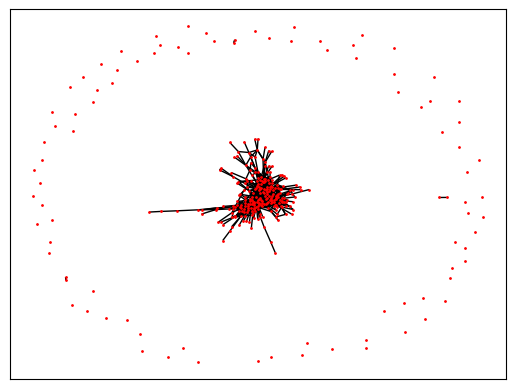

In [60]:
# visualize the graph - this is very ugly!
# the layout needs to be updated (same for the other graphs)
nx.draw_networkx(network, node_size=1, node_color="red", edge_color="black", with_labels=False)

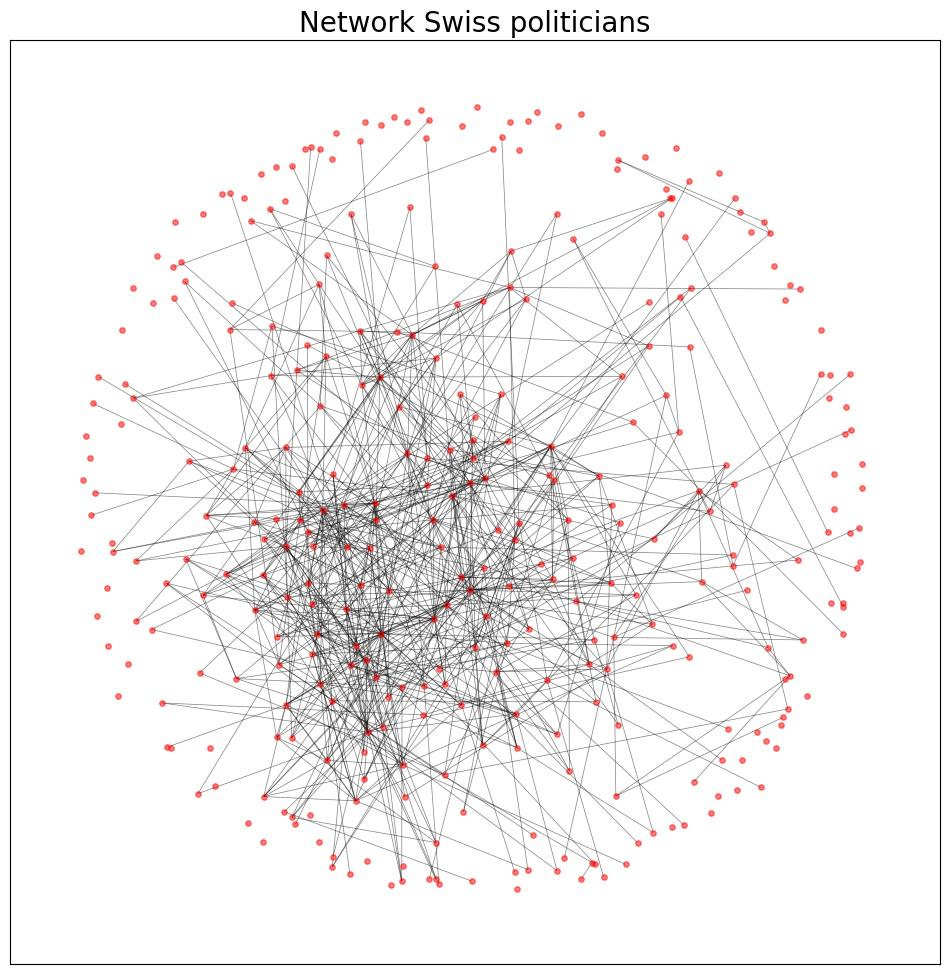

In [61]:
position=nx.spring_layout(network, k=0.8, iterations=90)
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_title('Network Swiss politicians', size=20)
nx.draw_networkx(network,pos=position, with_labels=False, node_size=15, width=0.5, alpha=0.5, node_color='red')

### To learn more:
Try to color each node according to the party affiliation.
* Get the party using ` nx.get_node_attributes() `
* You can use a dictionary to assign a color based on the party
* Pass the list of associated colors to the option ` node_color` from draw_networkx()

In [62]:
parties=nx.get_node_attributes(network, 'party')
party=[ parties.get(node) for node in list(network.nodes)]
color_party={'AL':'cyan', 'BDP':'salmon', 'CVP':'darkorange', 'EDU':'forestgreen', 'EVP':'mediumorchid', 'FDP':'gold', 'GLP':'steelblue', 'Green':'green', 'SP':'red', 'SVP':'brown', 'UP':'sienna'}
party_color=[color_party.get(part) for part in party[:-1]]

Text(0.5, 1.0, 'Swiss Politians (colored by party)')

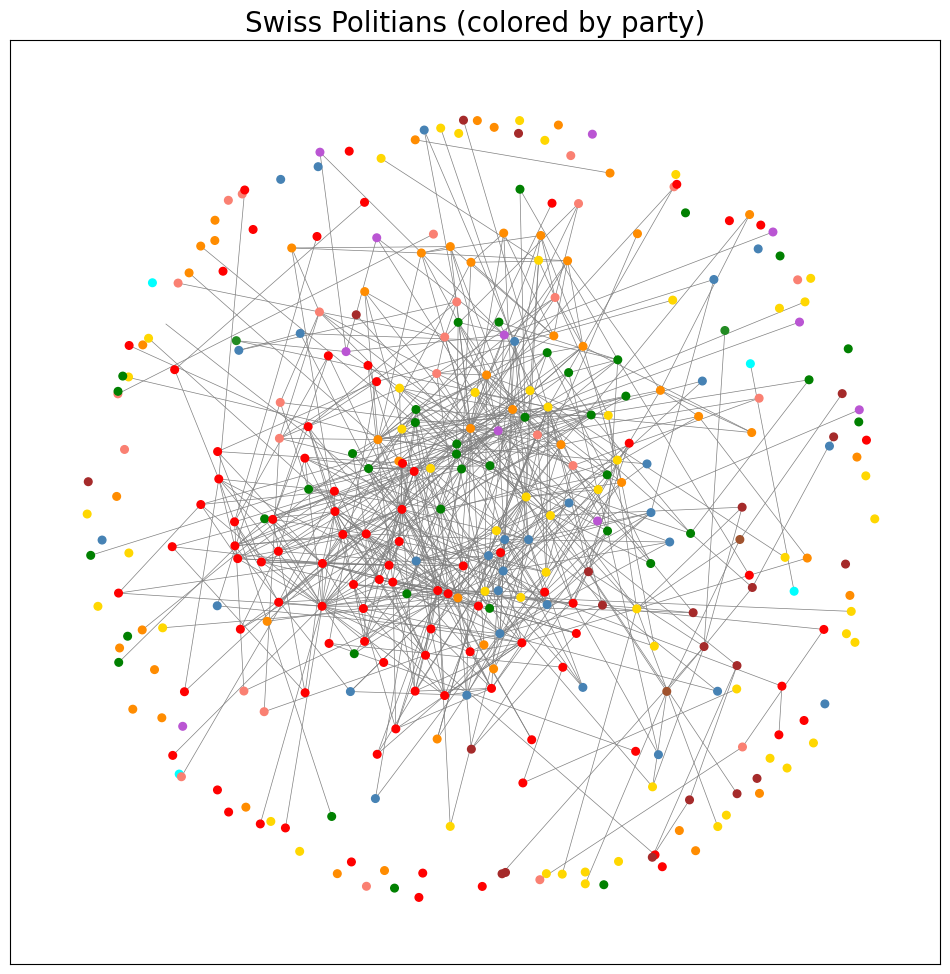

In [64]:
fig, ax = plt.subplots(figsize=(12, 12))
nx.draw_networkx(network,pos=position, with_labels=False, nodelist=list(network.nodes)[:-1], node_size=30, width=0.5, node_color=party_color, edge_color='grey')
ax.set_title("Swiss Politians (colored by party)",size=20)